So you have a catalog, huh? And you also have some images, huh? Maybe you want to examine them!

TODO:
    - [ ] explain what each parameter means HERE
    - [ ] give command that instead of running the creation, downloads the catalogs

In [1]:
%matplotlib inline
from scipy.ndimage import imread
import pandas as pd
from ast import literal_eval

from IPython.html.widgets import interact
from IPython.display import display
import mpld3
mpld3.enable_notebook()

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
base_directory = '/Users/cpd/Desktop/test/'
base_directory = '/nfs/slac/g/ki/ki18/cpd/swap_catalog/'

field_directory = base_directory + 'fields/'
cluster_directory = base_directory + 'clusters/'
augmented_directory = base_directory + 'augmented/'
catalog_path = cluster_directory + 'catalog.csv'
augmented_catalog_path = augmented_directory + 'augmented_catalog.csv'
knownlens_path = base_directory + 'knownlens.csv'
collection_path = base_directory + 'annotated_catalog.csv'

In [3]:
# run create catalog code. This can take a while.
from subprocess import call
command = ['python', './create_catalogs.py',
           '--collection', collection_path,
           '--knownlens', knownlens_path,
           '--clusters', cluster_directory,
           '--fields', field_directory,
           #'--augment', augmented_directory,
           #'--do_a_few', '100',
           ]
call(command)

0

In [9]:
if '.pickle' in collection_path:
    from create_catalogs import convert_swap_collection_to_dataframe
    # will need PJM's swap to interpret the spacewarps database
    try:
        import swap
    except:
        raise Exception('create_catalogs: Unable to import SpaceWarps analysis code!')

    #collection_path = base_collection_path + 'stage{0}'.format(stage) + '/CFHTLS_collection.pickle'
    collection_pickle = swap.read_pickle(collection_path, 'collection')
    stage = -1
    collection = convert_swap_collection_to_dataframe(collection_pickle, stage)
else:
    annotated_catalog = pd.read_csv(collection_path)
cluster_catalog = pd.read_csv(catalog_path)
#augmented_catalog = pd.read_csv(augmented_catalog_path)

In [99]:
# let's look at the known lens category of cutouts!
# catalog = cluster_catalog[cluster_catalog['cluster_type'] == 'known lens']
# catalog = cluster_catalog[(cluster_catalog['cluster_type'] == 'known lens') & (cluster_catalog['flavor'] == 'test')]
catalog = cluster_catalog[cluster_catalog['ZooID'] == 'ASW0005xjn']

In [23]:
print(cluster_catalog.columns)

Index([u'Unnamed: 0', u'ID', u'ZooID', u'location', u'mean_probability', u'category', u'kind', u'flavor', u'state', u'status', u'truth', u'stage', u'cluster_id', u'x', u'y', u'num_markers', u'skill_sum', u'tot_markers', u'cluster_marked_looks', u'total_marked_looks', u'total_looks', u'dispersion', u'field_name', u'cluster_name', u'cluster_type'], dtype='object')


blurb describing examine catalog function

In [25]:
def examine_catalog(catalog):
    def examine_cat(groupby_str):
        groupby_list = eval(groupby_str)
        print(catalog.groupby(groupby_list).apply(len))
        
    interact(examine_cat,
             groupby_str="['stage', 'flavor', 'cluster_type']")


examine_catalog(catalog)

stage
2        102
dtype: int64


In [31]:
examine_catalog(cluster_catalog)

stage  flavor           cluster_type             
1      dud              dud                          1789
       lensed galaxy    dud                           819
                        known lens                      9
                        simulated lensed galaxy      1939
       lensed quasar    dud                           766
                        known lens                      9
                        simulated lensed quasar      1984
       lensing cluster  dud                           713
                        known lens                     16
                        simulated lensing cluster    1948
2      dud              dud                           299
       lensed galaxy    dud                            53
                        known lens                      1
                        simulated lensed galaxy       151
       lensing cluster  dud                            29
                        simulated lensing cluster       8
       test           

If you don't have the annotated catalog, then you don't need to provide it to examine individual images. Of course, then the 'show_field' option will throw an error if marked True.

In [101]:
from create_catalogs import outlier_clusters_dbscan


def examine_cutouts(catalog, cluster_directory, annotated_catalog=None, field_directory=None,
                    plot_alpha=False, invert_color=False, color_by_user=False, plot_points=True):
    # some generic things you can configure:
    # what columns we want to plot

    if 'augment_type' in catalog.columns:
        columns = ['ZooID', 'cluster_id', 'stamp_id', 'stage', 'flavor', 'cluster_type', 'status',
                   'num_markers', 'tot_markers', 'cluster_marked_looks', 'total_marked_looks', 'total_looks', 
                   'dispersion', 'mean_probability', 'x', 'y', 'augment_type']
        augmented = True
    else:
        columns = ['ZooID', 'cluster_id', 'stage', 'flavor', 'cluster_type', 'status',
                   'num_markers', 'tot_markers', 'cluster_marked_looks', 'total_marked_looks', 'total_looks', 
                   'dispersion', 'mean_probability', 'x', 'y']
        augmented = False        
#     # by default the annotated image colors by group.
#     # we could color by user instead
#     color_by_user=False
#     # training images have an alpha layer. this is useful
#     # for debugging whether or not a training image was
#     # properly classified
#     plot_alpha=False
#     # sometimes it's really hard to see the tooltips since
#     # they are black and I have no idea how to change the color
#     invert_color=False
#     # for when you just want to see the field
#     plot_points=True
    def examine_entry(i, show_field=False):
        entry = catalog.iloc[i]
        ZooID = entry['ZooID']
        display(entry[columns])

        if augmented:
            cluster_path = augmented_directory + entry['stamp_name']
        else:
            cluster_path = cluster_directory + entry['cluster_name']
        
        cluster = imread(cluster_path) * 1. / 255.
        if invert_color:
            cluster = np.abs(cluster - cluster.max())
        
        if show_field:
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
            axs[0].imshow(cluster)
            cat = annotated_catalog.set_index(['ZooID'])

            entry = cat.loc[ZooID]
            # it is possible that we have ones from multiple stages
            if len(entry) == 2:
                # two stages, choose the one with the correct stage
                truth = entry['stage'].values == catalog.iloc[i]['stage']
                ith = int(np.argwhere(truth))
                entry = entry.iloc[ith]  # needs to be an int to return series. if array, returns dataframe


            if plot_points:
                x_unflat = literal_eval(entry['At_X'])
                y_unflat = literal_eval(entry['At_Y'])
                # flatten out x and y. also cut out empty entries
                x = np.array([xi for xj in x_unflat for xi in xj])
                y = np.array([yi for yj in y_unflat for yi in yj])

                users = np.array([xj for xj in xrange(len(x_unflat)) for xi in x_unflat[xj]])
                binusers = np.bincount(users)
                w = 1. / binusers[users]

                cluster_centers, cluster_labels, labels = outlier_clusters_dbscan(x, y)
                if color_by_user:
                    c = users
                else:
                    c = labels
                points = axs[1].scatter(x, y, c=c, s=50, alpha=0.8, cmap=plt.cm.Accent)
                tooltiplabels = ['({0}, {1}, {2})'.format(labels[i], users[i], w[i]) for i in xrange(len(labels))]
                tooltip = mpld3.plugins.PointLabelTooltip(points, tooltiplabels)
                mpld3.plugins.connect(fig, tooltip)

            field = imread(field_directory + ZooID + '.png') * 1. / 255. #entry['ZooID'] + '.png')
            if plot_alpha:
                if np.shape(field)[-1] == 4:
                    field = field[:, :, 3]
            else:
                field = field[:, :, :3]
            if invert_color:
                field = np.abs(field - field.max())
            IM = axs[1].imshow(field)
            mpld3.plugins.connect(fig, mpld3.plugins.MousePosition(fontsize=14))
        else:
            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
            cluster = imread(cluster_path)
            axs.imshow(cluster)
    
    interact(examine_entry,
             i=(0, len(catalog)-1+1),
             show_field=False)
    

people_marking_clusters
people_marking_field
markers_in_cluster
markers_in_field

dispersion -- cluster size

flavor -> field_flavor
cluster_type -> cluster_flavor

cluster -> object? spacewarps object catalog

since we won't share the annotated catalog, the field stuff goes away

some functions go into notebook_utils.py or somesuch
(have the release notebook just show the cutouts and other info; keep a diagnostic notebook for these things)

in tar: cutouts, catalog, utils, utils_py, readme

ZooID                      ASW0000ouo
cluster_id                       7460
stage                               1
flavor                  lensed quasar
cluster_type                      dud
status                       detected
num_markers                         5
tot_markers                       144
cluster_marked_looks                5
total_marked_looks                117
total_looks                       240
dispersion                   6.546396
mean_probability                    1
x                            306.5485
y                            182.0906
Name: 7460, dtype: object

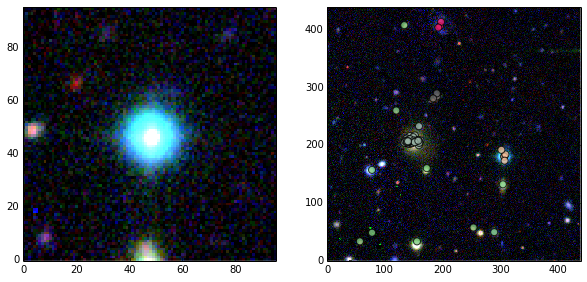

In [103]:
examine_cutouts(cluster_catalog, cluster_directory, annotated_catalog, field_directory,
                plot_alpha=False, invert_color=False, color_by_user=False, plot_points=True)

running list of failed clusters (by cluster_id):
    7 -- is sim lens cluster; should be dud (probably some bleedover of alpha in the corner)
    

ZooID                      ASW00015xe
cluster_id                       2341
stage                               1
flavor                  lensed quasar
cluster_type               known lens
status                       detected
num_markers                        23
tot_markers                       185
cluster_marked_looks               23
total_marked_looks                 96
total_looks                       103
dispersion                   8.247747
mean_probability                    1
x                            121.8711
y                            366.6559
Name: 2341, dtype: object

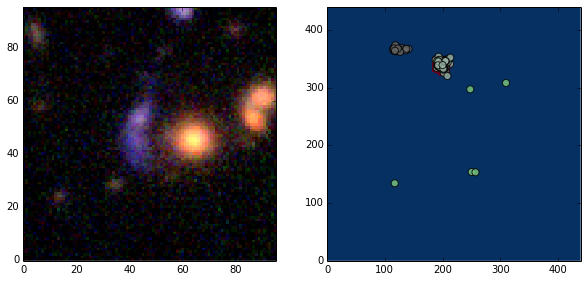

In [105]:
# and for the entire cluster catalog
catalog = cluster_catalog[(cluster_catalog['cluster_type'] == 'known lens') & (cluster_catalog['kind'] == 'sim')]
examine_cutouts(catalog, cluster_directory, annotated_catalog, field_directory,
                plot_alpha=True, invert_color=False, color_by_user=False, plot_points=True)

ZooID                                  ASW0000csg
cluster_id                                      7
stage                                           1
flavor                            lensing cluster
cluster_type            simulated lensing cluster
status                                   detected
num_markers                                    13
tot_markers                                   347
cluster_marked_looks                           13
total_marked_looks                            266
total_looks                                   301
dispersion                               8.898168
mean_probability                                1
x                                        27.81586
y                                        364.7828
Name: 7, dtype: object

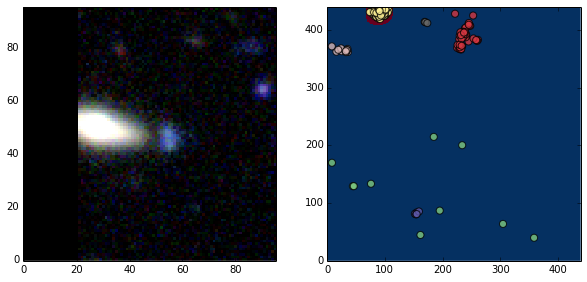

In [15]:
# and for the entire cluster catalog
examine_cutouts(cluster_catalog, cluster_directory, annotated_catalog, field_directory,
                plot_alpha=True, invert_color=False, color_by_user=False, plot_points=True)

TODO below: histogram that shows the ratio of cluster_marked_looks (number of users who clicked on this particular cluster) to total_looks or total_marked_looks (number of users who clicked generically) broken down by cluster_type and flavor categories. This way we can truly quantify the number of users who click on a dud in a lens system, or such.